In [38]:
NOTEBOOK_NAME = "e004_remove_yad_no"

In [39]:
import os
import pickle
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
import japanize_matplotlib
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

In [40]:
class Config:
    OUTPUT_DIR = f"../saved_data/{NOTEBOOK_NAME}"
    SEED = 33
    TARGET_COL = "reserve"


os.makedirs(Config.OUTPUT_DIR, exist_ok=True)

In [41]:
# train_log = pd.read_csv("../data/train_log.csv")
train_label = pd.read_csv("../data/train_label.csv")

test_log = pd.read_csv("../data/test_log.csv")
test_session = pd.read_csv("../data/test_session.csv")

yado = pd.read_csv("../data/yado.csv")

sample_submission = pd.read_csv("../data/sample_submission.csv")

# # image_embeddings = pd.read_parquet("../data/image_embeddings.parquet")

In [42]:
train = pd.read_pickle(
    f"../saved_data/e002_make_train/e002_make_train_merged_train.pkl"
)

test = pd.read_pickle(
    f"../saved_data/e001_make_test/e001_make_test_test_same_lrg_cd_wo_last_yad_no.pkl"
)

In [43]:
# # debug
# train = train.sample(10000, random_state=Config.SEED).reset_index(drop=True)
# test = test.sample(10000, random_state=Config.SEED).reset_index(drop=True)

In [44]:
# debug用
# train = train.sample(10000, random_state=SEED)

In [45]:
# ひとつ前のlogのyad_idの値を取得
train["previous_1_yad_no"] = train["logged_yad_no_list"].apply(lambda x: x[-1])
test["previous_1_yad_no"] = test["logged_yad_no_list"].apply(lambda x: x[-1])

In [46]:
train["session_id"].unique()

array(['000007603d533d30453cc45d0f3d119f',
       '0000ca043ed437a1472c9d1d154eb49b',
       '0000d4835cf113316fe447e2f80ba1c8', ...,
       'ffff7fb4617164b2604aaf51c40bf82d',
       'ffffcd5bc19d62cad5a3815c87818d83',
       'fffffa7baf370083ebcdd98f26a7e31a'], dtype=object)

# 正解のyadoと1つ前のyadoの情報の追加

In [47]:
train

,session_id,yad_no,reserve,logged_yad_no_list,previous_1_yad_no
0,000007603d533d30453cc45d0f3d119f,4101,1,[2395],2395
1,0000ca043ed437a1472c9d1d154eb49b,8253,1,[13535],13535
2,0000d4835cf113316fe447e2f80ba1c8,4863,1,[123],123
3,0000fcda1ae1b2f431e55a7075d1f500,1652,1,[8475],8475
4,000104bdffaaad1a1e0a9ebacf585f33,96,1,"[96, 898]",898
...,...,...,...,...,...
1732078,fffffa7baf370083ebcdd98f26a7e31a,1028,0,"[2439, 11822]",11822
1732079,fffffa7baf370083ebcdd98f26a7e31a,5607,0,"[2439, 11822]",11822
1732080,fffffa7baf370083ebcdd98f26a7e31a,532,0,"[2439, 11822]",11822
1732081,fffffa7baf370083ebcdd98f26a7e31a,11919,0,"[2439, 11822]",11822


In [48]:
# 正解のyado情報の追加
train = pd.merge(
    train,
    yado.add_prefix("now_"),
    left_on="yad_no",
    right_on="now_yad_no",
    how="left",
)

# 1つ前のyado情報の追加
train = pd.merge(
    train,
    yado.add_prefix("previous_1_"),
    on="previous_1_yad_no",
    how="left",
)

In [49]:
# 正解のyado情報の追加
test = pd.merge(
    test,
    yado.add_prefix("now_"),
    left_on="yad_no",
    right_on="now_yad_no",
    how="left",
)

# 1つ前のyado情報の追加
test = pd.merge(
    test,
    yado.add_prefix("previous_1_"),
    on="previous_1_yad_no",
    how="left",
)

In [50]:
train.head()

,session_id,yad_no,reserve,logged_yad_no_list,previous_1_yad_no,now_yad_no,now_yad_type,now_total_room_cnt,now_wireless_lan_flg,now_onsen_flg,...,previous_1_wireless_lan_flg,previous_1_onsen_flg,previous_1_kd_stn_5min,previous_1_kd_bch_5min,previous_1_kd_slp_5min,previous_1_kd_conv_walk_5min,previous_1_wid_cd,previous_1_ken_cd,previous_1_lrg_cd,previous_1_sml_cd
0,000007603d533d30453cc45d0f3d119f,4101,1,[2395],2395,4101,0,39.0,NaN,0,...,1.0,0,NaN,NaN,NaN,NaN,dc414a17890cfc17d011d5038b88ca93,d78f53d0856617bc782f02c3280dfef2,4fd631b15116098340cdb099c86a5a40,4044dac1931ddaa5a967e09506d76343
1,0000ca043ed437a1472c9d1d154eb49b,8253,1,[13535],13535,8253,0,26.0,1.0,0,...,1.0,0,1.0,NaN,NaN,1.0,b07b75d367ebece55a23ceecc939fff4,0a66f6ab9c0507059da6f22a0e1f1690,9ab5718fd88c6e5f9fec37a51827d428,7aff71bb47acb796d425c5ed5e6dfb3f
2,0000d4835cf113316fe447e2f80ba1c8,4863,1,[123],123,4863,0,30.0,1.0,0,...,1.0,0,NaN,NaN,NaN,NaN,46e33861f921c3e38b81998fbf283f01,572d60f0f5212aacda515ebf81fb0a3a,dac434451fe9bd50068191f41fe792e3,b7c56c5d2855b39366b4ebe9a4eded93
3,0000fcda1ae1b2f431e55a7075d1f500,1652,1,[8475],8475,1652,0,127.0,1.0,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,3a6cd37aa9e38fd96d9dafc2615643d0,f2fcbd8e62872147efde0acef474e1f2
4,000104bdffaaad1a1e0a9ebacf585f33,96,1,"[96, 898]",898,96,0,228.0,1.0,0,...,1.0,0,NaN,NaN,NaN,1.0,e9316013ee1b03f4525fe361c46ce9c5,84efa50e52f9b471c95bfc3b21b854ad,a1370d90ed3b80ee41311bbbab46aec9,d72674f02c5340d90f245e3177727650


In [51]:
test.head()

,session_id,yad_no,logged_yad_no_list,last_yad_no,previous_1_yad_no,now_yad_no,now_yad_type,now_total_room_cnt,now_wireless_lan_flg,now_onsen_flg,...,previous_1_wireless_lan_flg,previous_1_onsen_flg,previous_1_kd_stn_5min,previous_1_kd_bch_5min,previous_1_kd_slp_5min,previous_1_kd_conv_walk_5min,previous_1_wid_cd,previous_1_ken_cd,previous_1_lrg_cd,previous_1_sml_cd
0,00001149e9c73985425197104712478c,337,"[3560, 1959]",1959,1959,337,0,6.0,NaN,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0
1,00001149e9c73985425197104712478c,360,"[3560, 1959]",1959,1959,360,0,134.0,1.0,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0
2,00001149e9c73985425197104712478c,930,"[3560, 1959]",1959,1959,930,0,408.0,1.0,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0
3,00001149e9c73985425197104712478c,1063,"[3560, 1959]",1959,1959,1063,0,60.0,1.0,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0
4,00001149e9c73985425197104712478c,1286,"[3560, 1959]",1959,1959,1286,0,NaN,NaN,0,...,1.0,0,1.0,NaN,NaN,1.0,46e33861f921c3e38b81998fbf283f01,107c7305a74c8dcc4f143de208bf7ec2,52ca3d2824fc3cc90bd4274423badeed,87d9490219b3778f73c41b8176cf30d0


# データ型の変更

In [52]:
# categorical_colの定義
base_categorical_cols = [
    "yad_no",
    "yad_type",
    # "wid_cd", # retrieveの条件が同じlrg_cdのデータの予定のため、今は学習に使わない
    # "ken_cd", # retrieveの条件が同じlrg_cdのデータの予定のため、今は学習に使わない
    # "lrg_cd", # retrieveの条件が同じlrg_cdのデータの予定のため、今は学習に使わない
    "sml_cd",
]
now_yado_categorical_cols = [f"now_{col}" for col in base_categorical_cols]
previous_1_yado_categorical_cols = [
    f"previous_1_{col}" for col in base_categorical_cols
]

categorical_cols = now_yado_categorical_cols + previous_1_yado_categorical_cols

In [53]:
categorical_cols.remove("now_yad_no")
categorical_cols.remove("previous_1_yad_no")

# leak的な何かしらが起きているので、今は使わない
# TODO: 予測するyad_noは重要な情報だと思うため入れ方を考える

In [54]:
for col in categorical_cols:
    train[col] = train[col].astype("category")
    test[col] = test[col].astype("category")

# Fold

In [55]:
# Cross Validationの際に用いるfold(分割する際のグループ番号)を追加
FOLD_NUM = 5

# skf = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=42)
# for fold, (_, v_idx) in enumerate(
#     skf.split(train, pd.cut(train["reserve"], bins=3, labels=["0", "0.5", "1"]))
# ):
#     train.loc[v_idx, "fold"] = fold

sgkf = StratifiedGroupKFold(n_splits=FOLD_NUM, shuffle=True, random_state=Config.SEED)
for fold, (_, v_idx) in enumerate(
    sgkf.split(
        X=train,
        y=train["reserve"],
        groups=train["session_id"],
    )
):
    train.loc[v_idx, "fold"] = fold

train["fold"] = train["fold"].astype(int)

In [56]:
train.groupby("fold")["reserve"].value_counts(normalize=True)

fold  reserve
0     0          0.833324
      1          0.166676
1     0          0.833325
      1          0.166675
2     0          0.833321
      1          0.166679
3     0          0.833321
      1          0.166679
4     0          0.833325
      1          0.166675
Name: proportion, dtype: float64

# LightGBM

In [57]:
# numeric_colの定義
base_numeric_col = [
    "total_room_cnt",
    "wireless_lan_flg",
    "onsen_flg",
    "kd_stn_5min",
    "kd_bch_5min",
    "kd_slp_5min",
    "kd_conv_walk_5min",
]

now_yado_numeric_col = [f"now_{col}" for col in base_numeric_col]
previous_1_yado_numeric_col = [f"previous_1_{col}" for col in base_numeric_col]

numeric_cols = now_yado_numeric_col + previous_1_yado_numeric_col

In [58]:
use_col = numeric_cols + categorical_cols
len(use_col)

18

In [62]:
# LightGBMで用いるパラメーターを指定
# ref: https://lightgbm.readthedocs.io/en/v3.3.5/Parameters.html
params = {
    "objective": "binary",
    "metric": "binary_logloss",
    "max_depth": 3,  # TODO: 深くする
    # "min_data_in_leaf": 100, # 1つの葉に入る最小のデータ数
    "num_leaves": 24,  # 2**max_depthより少し小さめにすると過学習を防げる
    "learning_rate": 0.5,  # 1回のiterationで学習を進める割合、大きいと学習が早く終わる。小さいと学習は長いが高精度になりやすい。
    "bagging_freq": 5,  # 指定した回数ごとにbaggingを行う
    "feature_fraction": 0.9,  # 1回のiterationで利用する特徴量(列方向)の割合
    "bagging_fraction": 0.8,  # 1回のiterationで利用するデータ(行方向)の割合
    "verbose": -1,  # 出力するログレベルの変更、0はError(Warning)以上を表示
    "seed": 42,  # ランダムシードの固定
    "lambda_l1": 0.4,
    "lambda_l2": 0.4,
    "importance_type": "gain",
}

In [60]:
# def rmse(y_true, y_pred):
#     return np.sqrt(mean_squared_error(y_true, y_pred))

In [63]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    # foldごとにtrainとvalidに分ける
    train_fold = train[train["fold"] != fold]
    valid_fold = train[train["fold"] == fold]

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.drop(Config.TARGET_COL, axis=1)
    X_valid = valid_fold.drop(Config.TARGET_COL, axis=1)
    y_train = train_fold[[Config.TARGET_COL]]
    y_valid = valid_fold[[Config.TARGET_COL]]

    # 利用する説明変数に限定する
    X_train = X_train[use_col]
    X_valid = X_valid[use_col]

    # LightGBMが認識可能な形にデータセットを変換
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)

    # モデルの学習
    model = lgb.train(
        params,
        lgb_train,
        num_boost_round=3000,  # 学習のiteration回数
        valid_sets=[lgb_train, lgb_eval],
        callbacks=[
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(100),
        ],  # Early stopingの回数、binary_loglossが改善しないiterationが100回続いたら学習を止める
    )

    # モデルを保存
    models.append(model)

    # validデータに対する推論
    y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)

    # validデータに対する推論の性能を計算
    # score = rmse(y_valid, y_valid_pred)
    score = roc_auc_score(y_valid, y_valid_pred)

    print(f"fold {fold} Score: {score}")

    # oofに推論結果を保存
    valid_idx = X_valid.index
    oof[valid_idx] = y_valid_pred

    # 最終的には全部回すが、暫くは1foldのみで止める
    break

Start fold 0
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.284636	valid_1's binary_logloss: 0.287553
[200]	training's binary_logloss: 0.246145	valid_1's binary_logloss: 0.249863
[300]	training's binary_logloss: 0.228595	valid_1's binary_logloss: 0.232658
[400]	training's binary_logloss: 0.216235	valid_1's binary_logloss: 0.220591
[500]	training's binary_logloss: 0.206875	valid_1's binary_logloss: 0.211385
[600]	training's binary_logloss: 0.196699	valid_1's binary_logloss: 0.201582
[700]	training's binary_logloss: 0.192324	valid_1's binary_logloss: 0.197333
[800]	training's binary_logloss: 0.187574	valid_1's binary_logloss: 0.192729
[900]	training's binary_logloss: 0.183663	valid_1's binary_logloss: 0.188927
[1000]	training's binary_logloss: 0.18107	valid_1's binary_logloss: 0.186499
[1100]	training's binary_logloss: 0.178824	valid_1's binary_logloss: 0.18448
[1200]	training's binary_logloss: 0.176851	valid_1's binary_logloss: 0.182557


In [64]:
# oof_score = rmse(train[Config.TARGET_COL][oof != 0], oof[oof != 0])
oof_score = roc_auc_score(train[Config.TARGET_COL][oof != 0], oof[oof != 0])
oof_score

0.9594482039449845

In [65]:
# map@10を計算
def create_top_10_yad_predict(oof: pd.DataFrame, train: pd.DataFrame) -> pd.DataFrame:
    # 計算を行なった行に限定する
    train = train[oof != 0]
    oof = oof[oof != 0]

    _df = pd.concat(
        [train[["session_id", "yad_no"]], pd.Series(oof, name="predict")],
        axis=1,
    )

    # セッションごとに予測確率の高い順に yad_no の配列を作成
    _agg = (
        _df.sort_values("predict", ascending=False)
        .groupby("session_id")["yad_no"]
        .apply(list)
    )

    out_df = pd.DataFrame(index=_agg.index, data=_agg.values.tolist()).iloc[:, :10]
    out_df = out_df.fillna("0").astype(int)

    return out_df


oof_label_df = create_top_10_yad_predict(oof=oof, train=train)

oof_label_df

,0,1,2,3,4,5
session_id,,,,,,
000007603d533d30453cc45d0f3d119f,7448,4101,1648,1987,13268,7281
00011afe25c343301ee961b3b0ce2e4d,4823,5401,1540,5915,12929,1502
00026fd325b5d65d18e6de78ea2a3751,756,12746,2813,4038,11931,13484
0003948318658b2072bc29e99415743e,569,11480,6597,3476,607,7610
00044db9da5da40b1e0056ba487cdc28,1383,6787,7871,2759,1673,800
...,...,...,...,...,...,...
fffba437ec6fc44941b01c236e864dfd,8833,5328,9559,7473,10723,8053
fffc46c700754a5930e83ce0a7df19c9,2145,11480,3380,2180,569,5038
fffd7802cfb01ed4fd26225816f3d794,925,5344,9722,7598,10723,8082


In [66]:
def apk(actual, predicted, k=10):
    """
    Computes the average precision at k for a single actual value.

    Parameters:
    actual : int
        The actual value that is to be predicted
    predicted : list
        A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The average precision at k
    """
    if actual in predicted[:k]:
        return 1.0 / (predicted[:k].index(actual) + 1)
    return 0.0


def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k for lists of actual values and predicted values.

    Parameters:
    actual : list
        A list of actual values that are to be predicted
    predicted : list
        A list of lists of predicted elements (order does matter in the lists)
    k : int, optional
        The maximum number of predicted elements

    Returns:
    float
        The mean average precision at k
    """
    return sum(apk(a, p, k) for a, p in zip(actual, predicted)) / len(actual)

In [67]:
# いま作成した session_id と同じ並びで train_label を並び替え
sorted_train_label = (
    train_label.set_index("session_id").loc[oof_label_df.index]["yad_no"].values
)

In [68]:
# MAPK (k=10) として計算
oof_mapk_score = mapk(
    actual=sorted_train_label,
    predicted=oof_label_df.values.tolist(),
    k=10,
)
oof_mapk_score

0.9973992160122851

<Axes: >

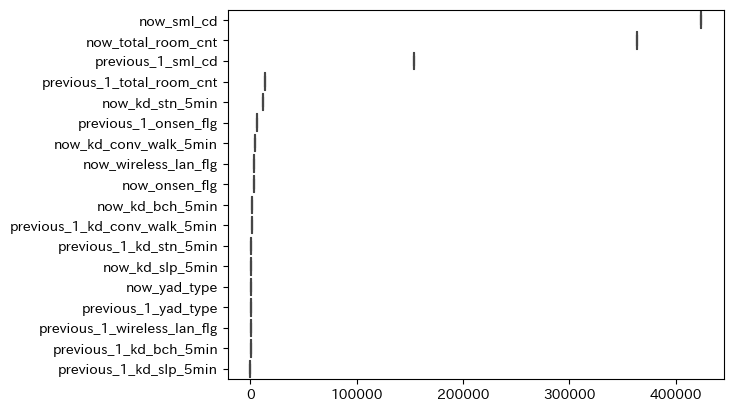

In [69]:
# 特徴量重要度を列にもつDataFrameを作成
feature_importances = [
    model.feature_importance(importance_type="gain") for model in models
]
feature_importances_df = pd.DataFrame(feature_importances, columns=use_col)

# 表示する順番を指定、特徴量重要度の平均が大きい順に並ぶよう計算
order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()

# 表示
# fold毎の特徴量重要度のばらつきを見るために、箱ひげ図を利用
sns.boxplot(data=feature_importances_df, orient="h", order=order)

In [71]:
with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_models.pkl", "wb") as f:
    pickle.dump(models, f)

with open(f"{Config.OUTPUT_DIR}/{NOTEBOOK_NAME}_oof.pkl", "wb") as f:
    pickle.dump(oof, f)

# Testに対する推論

In [72]:
# k 個のモデルの予測を作成. shape = (5, N_test,).
pred = np.array([model.predict(test[use_col]) for model in models])

# k 個のモデルの予測値の平均 shape = (N_test,).
pred = np.mean(pred, axis=0)  # axis=0 なので shape の `k` が潰れる

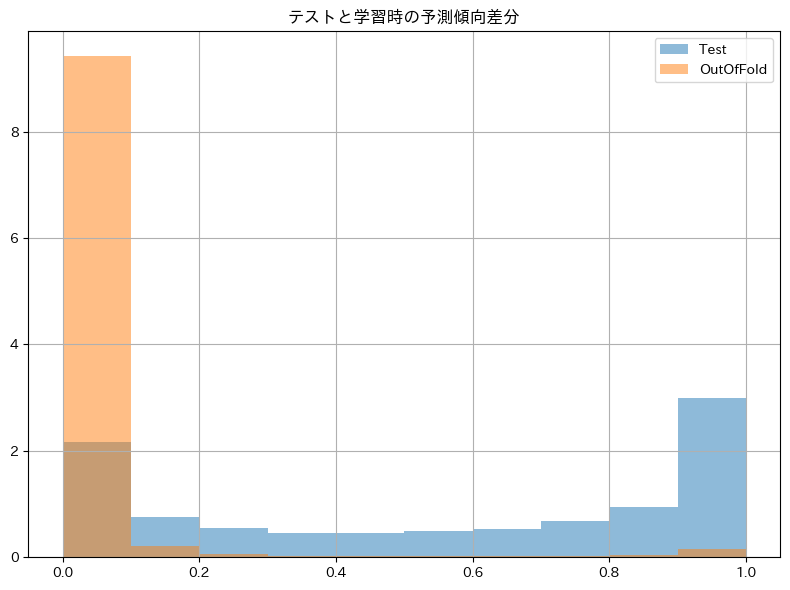

In [73]:
fig, ax = plt.subplots(figsize=(8, 6))

vmax = 0.02
# bins = np.linspace(0, 1, 0.1)
ax.hist(pred, density=True, alpha=0.5, label="Test")
ax.hist(oof, density=True, alpha=0.5, label="OutOfFold")
ax.grid()
ax.legend()
ax.set_title("テストと学習時の予測傾向差分")

fig.tight_layout()

In [74]:
test["pred"] = pred

In [75]:
# session_idごとにpredが高いyadoのlistを取得
pred_yad = (
    test.sort_values(["session_id", "pred"], ascending=False)
    .groupby("session_id")["yad_no"]
    .apply(list)
).to_dict()

In [76]:
test_session["pred_yad_no_list"] = test_session["session_id"].map(pred_yad)

In [77]:
# 上位10件に限定
test_session["pred_yad_no_list_top10"] = test_session["pred_yad_no_list"].apply(
    lambda x: x[:10]
)

In [78]:
# listをpd.Seriesに変換
pred_yad_df = test_session["pred_yad_no_list_top10"].apply(pd.Series)
pred_yad_df = pred_yad_df.rename(columns=lambda x: "predict_" + str(x))

In [79]:
pred_yad_df.head()

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,8905.0,12080.0,11930.0,4948.0,6766.0,4545.0,360.0,9830.0,10577.0,10965.0
1,6346.0,9323.0,10023.0,1059.0,143.0,11340.0,11986.0,6555.0,6246.0,8108.0
2,1774.0,6721.0,10485.0,410.0,10104.0,9910.0,757.0,9708.0,2267.0,7710.0
3,12341.0,2363.0,6489.0,9319.0,10861.0,10535.0,1542.0,13521.0,3359.0,10527.0
4,11664.0,101.0,5713.0,6047.0,9611.0,6885.0,2355.0,13235.0,494.0,5453.0


In [80]:
pred_yad_df.isnull().sum()

predict_0      0
predict_1      0
predict_2      0
predict_3      0
predict_4     47
predict_5    159
predict_6    476
predict_7    619
predict_8    735
predict_9    953
dtype: int64

In [81]:
# Nullの箇所はyad_no=0で保管し、全ての値をintに変換する
pred_yad_df = pred_yad_df.fillna(0).astype(int)

In [82]:
assert pred_yad_df.shape[0] == sample_submission.shape[0]
assert list(pred_yad_df.columns) == list(sample_submission.columns)

In [83]:
pred_yad_df.to_csv(
    f"../sub/{NOTEBOOK_NAME}_auc{oof_score:.4f}_mapk{oof_mapk_score:.4f}.csv",
    index=False,
)

In [84]:
pred_yad_df

,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,8905,12080,11930,4948,6766,4545,360,9830,10577,10965
1,6346,9323,10023,1059,143,11340,11986,6555,6246,8108
2,1774,6721,10485,410,10104,9910,757,9708,2267,7710
3,12341,2363,6489,9319,10861,10535,1542,13521,3359,10527
4,11664,101,5713,6047,9611,6885,2355,13235,494,5453
...,...,...,...,...,...,...,...,...,...,...
174695,3440,8771,2278,6813,10166,4889,7888,11848,831,5744
174696,9634,13627,5538,920,5392,9643,3163,1749,12739,12947
174697,11850,5944,11355,1188,12425,12351,2927,11037,6371,8760
174698,10989,3100,5984,6895,4049,3002,5515,2818,5251,12043


In [ ]:
sample_submission